In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob # To import all the calibration images

In [50]:
class Lines():
    def __init__(self,first=True,recent_xfitted=[],bestx=None,best_fit=None,current_fit=[np.array([False])],radius_of_curvature = None,line_base_pos = None,diffs = np.array([0,0,0], dtype='float'),allx = None,ally=None):
        # was the line detected in the last iteration?
        self.first = first
        # x values of the last n fits of the line
        self.recent_xfitted = recent_xfitted
        #average x values of the fitted line over the last n iterations
        self.bestx = bestx
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = best_fit
        #polynomial coefficients for the most recent fit
        self.current_fit = current_fit
        #radius of curvature of the line in some units
        self.radius_of_curvature = radius_of_curvature
        #distance in meters of vehicle center from the line
        self.line_base_pos = line_base_pos
        #difference in fit coefficients between last and new fits
        self.diffs = diffs
        #x values for detected line pixels
        self.allx = allx
        #y values for detected line pixels
        self.ally = ally
        self.frame_number = 0
        
    def calibrate(self,objpoints=[],imgpoints=[]):
        self.objpoints = objpoints
        self.imgpoints = imgpoints
        self.objp = np.zeros((6*9,3), np.float32) 
        self.objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

    # Make a list of calibration images
        images = glob.glob('/Users/abylikhsanov1/AI/carnd/term1/advanced-lane-lines/camera_cal/calibration*.jpg') # Please update if needed
        for fname in images:
            image = cv2.imread(fname)
            img_size = (image.shape[1],image.shape[0])
            gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
            ret, corners = cv2.findChessboardCorners(gray, (9,6), None) # Finding any distorted pixel locations
            if ret is True: # If we found any, we shall append the coordinates and the pixels itself
                self.objpoints.append(self.objp)
                self.imgpoints.append(corners)
                cv2.drawChessboardCorners(image, (9,6), corners, ret)
        ret, self.mtx, self.dist, rvecs, tvecs = cv2.calibrateCamera(self.objpoints, self.imgpoints,img_size,None,None) # Calibration, moving imgpoints towards the coordinate
        cv2.destroyAllWindows()
        
    def process_image(self,img):
        %matplotlib inline
        self.frame_number = self.frame_number + 1
        self.img = img # Now, let's undistort our first road image
    # Calibrating and removing the distortion
        img_size = (self.img.shape[1],self.img.shape[0]) # We are making img_size[0] as x axis values and [1] as y axis
        self.dst = cv2.undistort(self.img, self.mtx, self.dist, None, self.mtx)

        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.imshow(self.img)
        ax1.set_title('Original Image', fontsize=30)
        ax2.imshow(self.dst)
        ax2.set_title('Undistorted Image', fontsize=30)
        self.combined_binary = self.gradient()
        self.warp()
        if(self.frame_number <= 1):
            print(self.frame_number)
            self.first_plot()
        else:
            self.search()
        self.unwarp()
        
    def sobel(self,i,ksize=3,thresh=(0,255)):
        self.i = i
        sobelx = cv2.Sobel(self.i,cv2.CV_64F,1,0,ksize=ksize)
        sobel_abs = np.absolute(sobelx)
        sobel_binary = np.uint8(255*sobel_abs/np.max(sobel_abs))
        empty = np.zeros_like(sobel_binary)
        empty[(sobel_binary >= thresh[0]) & (sobel_binary <= thresh[1])] = 1
        return empty

    def magnitude(self,img,ksize=3,thresh=(0,255)):
        sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=ksize)
        sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=ksize)
        sobel_abs = np.absolute(sobelx+sobely)
        sobel_bin = np.uint8(255*sobel_abs/np.max(sobel_abs))
        empty = np.zeros_like(sobel_bin)
        empty[(sobel_bin >= thresh[0]) & (sobel_bin<= thresh[1])] = 1
        return empty

    def direction(self,img,ksize=3,thresh=(0,255)):
        sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=ksize)
        sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=ksize)
        sobel_bin = np.arctan(np.absolute(sobelx),np.absolute(sobely))
        empty = np.zeros_like(sobel_bin)
        empty[(sobel_bin >= thresh[0]) & (sobel_bin <= thresh[1])] = 1
        return empty
    def gradient(self):
        self.hls = cv2.cvtColor(self.dst,cv2.COLOR_RGB2HLS)
        self.gray = cv2.cvtColor(self.dst,cv2.COLOR_RGB2GRAY)
        self.luv = cv2.cvtColor(self.dst,cv2.COLOR_RGB2LUV)
        r = (230,255)
        g = (230,255)
        s = (10,200)
        l = (1,120)

        r_mag = self.sobel(self.dst[:,:,0],3,r)
        g_mag = self.sobel(self.dst[:,:,1],3,g)
        s_mag = self.sobel(self.hls[:,:,2],9,s)
        l_mag = self.magnitude(self.luv[:,:,0],9,l)
        self.combined_binary = np.zeros_like(r_mag)
        self.combined_binary[((r_mag==1) & (g_mag==1)) | (s_mag==1)] = 1
    
        if len(self.combined_binary.shape) > 2:
            channel_count = self.combined_binary.shape[2]  # i.e. 3 or 4 depending on your image
            ignore_mask_color = (255,) * channel_count
        else:
            ignore_mask_color = 255
        
        vertices = np.int32([[[190,700],[560,450],[800,450],[1200,700]]])
        mask = np.zeros_like(self.combined_binary)
        cv2.fillPoly(mask, vertices,ignore_mask_color)
        self.combined_binary = cv2.bitwise_and(self.combined_binary, mask)
        fig,(ax1) = plt.subplots(1,1,figsize=(10,5))
        ax1.imshow(self.combined_binary,cmap='gray')
        ax1.set_title('Result from the gradient function')
        return self.combined_binary
    
    def warp(self):
        self.img_size = (self.combined_binary.shape[1],self.combined_binary.shape[0])
        self.bottom_left = [320,720] 
        self.bottom_right = [980, 720]
        self.top_left = [320, 0]
        self.top_right = [980, 0]
        self.src = np.float32([[261,720],[559,475],[713,475],[1200,720]])
#src = np.float32([[256,688],[544,500],[752,500],[1000,688]])
        self.dest = np.float32([self.bottom_left,self.top_left,self.top_right,self.bottom_right])
        self.M = cv2.getPerspectiveTransform(self.src,self.dest)
        self.warped = cv2.warpPerspective(self.combined_binary,self.M,self.img_size)
# Plotting warped and non images
        f, (ax1) = plt.subplots(1, 1, figsize=(10,5))
        ax1.set_title('Output from the Warped function')
        ax1.imshow(self.warped,cmap='gray')
        
    
    def first_plot(self):
        self.histogram = np.sum(self.warped[int(self.warped.shape[0]/2):,:],axis=0)
        self.midpoint = int(self.histogram.shape[0]/2)
        self.left_side = np.argmax(self.histogram[:self.midpoint]) # Getting the most dense pixel region at x axis, argmax returns the index
        self.right_side = np.argmax(self.histogram[self.midpoint:]) + self.midpoint # Getting the most dense pixel region at x axis right side
# As the maximum Y value is 720, I will choose to divide it to 9 windows
        self.windows = 9

# Set height of windows
        self.window_height = np.int(self.warped.shape[0]/self.windows) # In this code, this is int size of 80 (80 pixels)

# Identify the x and y positions of all nonzero pixels in the image
        self.nonzero = self.warped.nonzero() # Pixel locations where pixel is 1, [1] = x, [0] = y
        self.nonzeroy = np.array(self.nonzero[0]) 
        self.nonzerox = np.array(self.nonzero[1])

# Current positions to be updated for each window
        leftx_current = self.left_side 
        rightx_current = self.right_side

# Set the width of the windows +/- margin
        self.margin = 100
# Set minimum number of pixels found to recenter window
        self.minpix = 50
        self.margin = 100
# Set minimum number of pixels found to recenter window
        self.minpix = 50
# Create empty lists to receive left and right lane pixel indices
        self.left_lane_inds = []
        self.right_lane_inds = []
        for window in range(self.windows):
            win_y_low = self.warped.shape[0] - (window+1)*self.window_height # Loop 1, 0+1 * 80 = 80 px
            win_y_high = self.warped.shape[0] - window*self.window_height # Loop 1, 0 px, this is a top value, as y values are from the top to the bottom
            win_xleft_low = self.left_side - self.margin # Setting the square boundaries, from the current found lane piece
            win_xleft_high = self.left_side + self.margin
            win_xright_low = self.right_side - self.margin
            win_xright_high = self.right_side + self.margin
            good_left = ((self.nonzeroy>=win_y_low)&(self.nonzeroy<win_y_high)&(self.nonzerox>=win_xleft_low)&(self.nonzerox<win_xleft_high)).nonzero()[0]
            good_right = ((self.nonzeroy>=win_y_low)&(self.nonzeroy<win_y_high)&(self.nonzerox>=win_xright_low)&(self.nonzerox<win_xright_high)).nonzero()[0]
            self.left_lane_inds.append(good_left)
            self.right_lane_inds.append(good_right)
            if((len(good_left)) > 50):
                leftx_current = np.int(np.mean(self.nonzerox[good_left]))
            if((len(good_right)) > 50):
                rightx_current = np.int(np.mean(self.nonzerox[good_right]))
            elif((len(good_right)) < 50):
                rightx_current = np.int(np.mean(self.nonzerox[good_left]+self.midpoint))
            
        
        self.left_lane_inds = np.concatenate(self.left_lane_inds)
        self.right_lane_inds = np.concatenate(self.right_lane_inds)
        self.leftx = self.nonzerox[self.left_lane_inds]
        self.lefty = self.nonzeroy[self.left_lane_inds] 
        self.rightx = self.nonzerox[self.right_lane_inds]
        self.righty = self.nonzeroy[self.right_lane_inds]
        # Fit a second order polynomial to each
        self.left_fit = np.polyfit(self.lefty, self.leftx, 2)
        self.right_fit = np.polyfit(self.righty, self.rightx, 2)
        self.ploty = np.linspace(0,self.warped.shape[0]-1,self.warped.shape[0])
        self.left_fitx = self.left_fit[0]*self.ploty**2 + self.left_fit[1]*self.ploty + self.left_fit[2]
        self.right_fitx = self.right_fit[0]*self.ploty**2 + self.right_fit[1]*self.ploty + self.right_fit[2]
        out_img = np.dstack((self.warped, self.warped, self.warped))*255
        window_img = np.zeros_like(out_img) # Getting the blank image to display the curves
# Color in left and right line pixels
        out_img[self.nonzeroy[self.left_lane_inds], self.nonzerox[self.left_lane_inds]] = [255, 0, 0]
        out_img[self.nonzeroy[self.right_lane_inds], self.nonzerox[self.right_lane_inds]] = [0, 0, 255]
# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([self.left_fitx, self.ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([self.left_fitx+(self.right_fitx-self.left_fitx),
                                                                        self.ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
# Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        self.result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        fig,(ax1) = plt.subplots(1,1,figsize=(10,15))
        ax1.imshow(self.result)
        ax1.set_title('Output from the first fit method')
        
    def search(self):
        self.left_lane_inds = []
        self.right_lane_inds = []
        self.histogram = np.sum(self.warped[int(self.warped.shape[0]/2):,:],axis=0)
        self.left_side = np.argmax(self.histogram[:self.midpoint]) 
        self.right_side = np.argmax(self.histogram[self.midpoint:]) + self.midpoint
        leftx_current = self.left_side 
        rightx_current = self.right_side
        self.break_search = 0
        for window in range(self.windows):
            win_y_low = self.warped.shape[0] - (window+1)*self.window_height # Loop 1, 0+1 * 80 = 80 px
            win_y_high = self.warped.shape[0] - window*self.window_height # Loop 1, 0 px, this is a top value, as y values are from the top to the bottom
            win_xleft_low = self.left_side - self.margin # Setting the square boundaries, from the current found lane piece
            win_xleft_high = self.left_side + self.margin
            win_xright_low = self.right_side - self.margin
            win_xright_high = self.right_side + self.margin
            good_left = ((self.nonzeroy>=win_y_low)&(self.nonzeroy<win_y_high)&
                         (self.nonzerox>=win_xleft_low)&(self.nonzerox<win_xleft_high)).nonzero()[0]
            good_right = ((self.nonzeroy>=win_y_low)&(self.nonzeroy<win_y_high)&
                         (self.nonzerox>=win_xright_low)&(self.nonzerox<win_xright_high)).nonzero()[0]
            self.left_lane_inds.append(good_left)
            self.right_lane_inds.append(good_right)
            if((len(good_left)) > 50):
                leftx_current = np.int(np.mean(self.nonzerox[good_left]))
            if((len(good_right)) > 50):
                rightx_current = np.int(np.mean(self.nonzerox[good_right]))
            elif((len(good_right)) < 50):
                self.break_search = 1
                break
        if(self.break_search==0):
            self.left_lane_inds = np.concatenate(self.left_lane_inds)
            self.right_lane_inds = np.concatenate(self.right_lane_inds)
            self.leftx = self.nonzerox[self.left_lane_inds]
            self.lefty = self.nonzeroy[self.left_lane_inds] 
            self.rightx = self.nonzerox[self.right_lane_inds]
            self.righty = self.nonzeroy[self.right_lane_inds]
            # Fit a second order polynomial to each
            self.left_fit = np.polyfit(self.lefty, self.leftx, 2)
            self.right_fit = np.polyfit(self.righty, self.rightx, 2)
            self.left_fitx = self.left_fit[0]*self.ploty**2 + self.left_fit[1]*self.ploty + self.left_fit[2]
            self.right_fitx = self.right_fit[0]*self.ploty**2 + self.right_fit[1]*self.ploty + self.right_fit[2]
            out_img = np.dstack((self.warped, self.warped, self.warped))*255
            window_img = np.zeros_like(out_img) # Getting the blank image to display the curves
            # Color in left and right line pixels
            out_img[self.nonzeroy[self.left_lane_inds], self.nonzerox[self.left_lane_inds]] = [255, 0, 0]
            out_img[self.nonzeroy[self.right_lane_inds], self.nonzerox[self.right_lane_inds]] = [0, 0, 255]
           # Generate a polygon to illustrate the search window area
           # And recast the x and y points into usable format for cv2.fillPoly()
            left_line_window1 = np.array([np.transpose(np.vstack([self.left_fitx, self.ploty]))])
            left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([self.left_fitx+(self.right_fitx-self.left_fitx),
                                                                        self.ploty])))])
            left_line_pts = np.hstack((left_line_window1, left_line_window2))
          # Draw the lane onto the warped blank image
            cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
            self.result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
            fig,(ax1) = plt.subplots(1,1,figsize=(10,15))
            ax1.imshow(self.result)
            ax1.set_title('Output from the search method')
        elif(self.break_search==1):
            self.skip_search()
        
    
    def skip_search(self):
        left_lane_inds = ((self.nonzerox > (self.left_fit[0]*(self.nonzeroy**2) + self.left_fit[1]*self.nonzeroy + 
                                       self.left_fit[2] - self.margin)) &
                          (self.nonzerox < (self.left_fit[0]*(self.nonzeroy**2) + self.left_fit[1]*self.nonzeroy + 
                                            self.left_fit[2] + self.margin))) 
        right_lane_inds = ((self.nonzerox > (self.right_fit[0]*(self.nonzeroy**2) + self.right_fit[1]*self.nonzeroy + 
                                        self.right_fit[2] - self.margin)) & 
                           (self.nonzerox < (self.right_fit[0]*(self.nonzeroy**2) + self.right_fit[1]*self.nonzeroy + 
                                             self.right_fit[2] + self.margin)))
        leftx = self.nonzerox[left_lane_inds]
        lefty = self.nonzeroy[left_lane_inds] 
        rightx = self.nonzerox[right_lane_inds]
        righty = self.nonzeroy[right_lane_inds]
        # Fit a second order polynomial to each
        self.left_fit = np.polyfit(lefty, leftx, 2)
        self.right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
        self.left_fitx = self.left_fit[0]*self.ploty**2 + self.left_fit[1]*self.ploty + self.left_fit[2]
        self.right_fitx = self.right_fit[0]*self.ploty**2 + self.right_fit[1]*self.ploty + self.right_fit[2]
        out_img = np.dstack((self.warped, self.warped, self.warped))*255
        window_img = np.zeros_like(out_img) # Getting the blank image to display the curves
# Color in left and right line pixels
        out_img[self.nonzeroy[left_lane_inds], self.nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[self.nonzeroy[right_lane_inds], self.nonzerox[right_lane_inds]] = [0, 0, 255]
# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([self.left_fitx, self.ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([self.left_fitx+(self.right_fitx-self.left_fitx),self.ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
# Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        self.result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        fig,(ax1) = plt.subplots(1,1,figsize=(10,15))
        ax1.imshow(self.result)
        ax1.set_title('Output from the skip search method')
        
    def unwarp(self):
        warp_zero = np.zeros_like(self.result)
        dest = self.src
        img_size = (self.result.shape[1],self.result.shape[0])
        bottom_left = [self.left_fitx[-1],self.result.shape[0]] 
        bottom_right = [self.right_fitx[-1], self.result.shape[0]]
        top_left = [self.left_fitx[0], 0]
        top_right = [self.right_fitx[0], 0]
        src = np.float32([bottom_left,top_left,top_right,bottom_right])
        pts_left = np.array([np.transpose(np.vstack([self.left_fitx, self.ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([self.right_fitx, self.ploty])))])
        pts = np.hstack((pts_left, pts_right))
        cv2.fillPoly(warp_zero, np.int_([pts]), (0,255,0))
        M_inv = cv2.getPerspectiveTransform(src,dest)
        self.unwarped = cv2.warpPerspective(warp_zero,M_inv,self.img_size)
        # Combine the result with the original image
        final = cv2.addWeighted(self.dst, 1, self.unwarped, 0.3, 0)
        plt.imshow(final)
            

        
  

In [55]:
left = Lines()

In [56]:
left.calibrate()

In [44]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

1


AttributeError: 'NoneType' object has no attribute 'shape'

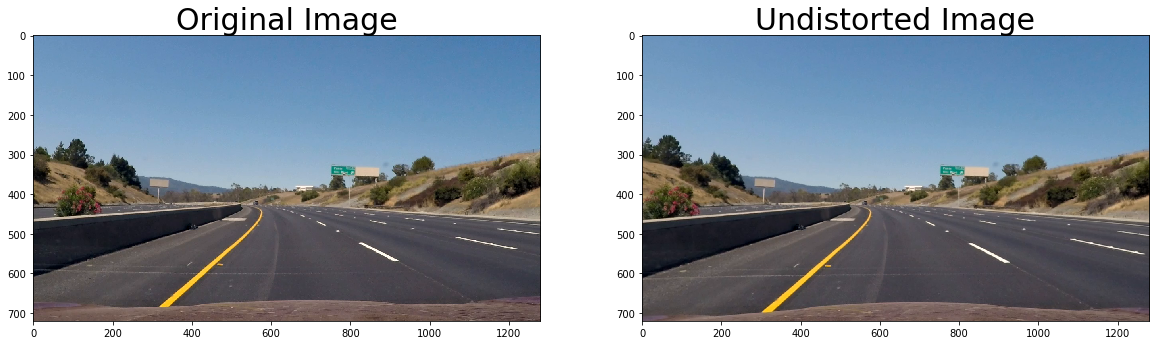

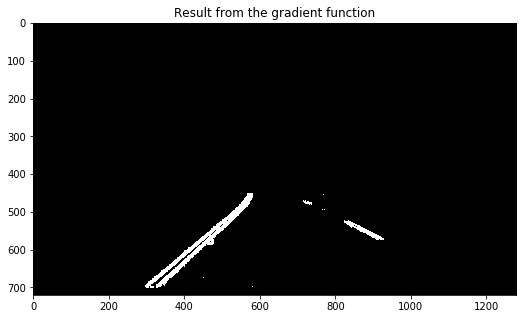

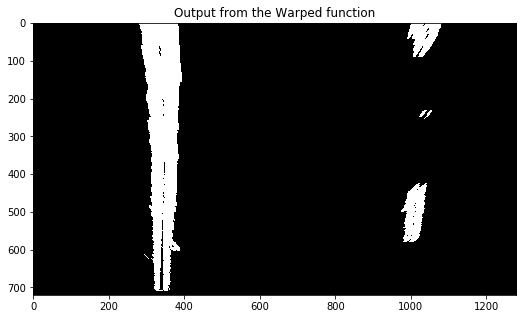

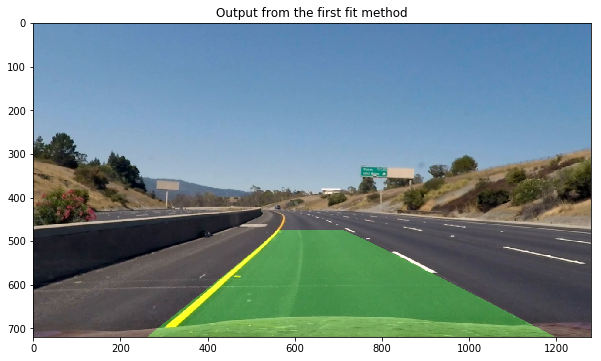

In [57]:
white_output = 'output_videos/project_video.mp4'
clip1 = VideoFileClip("project_video.mp4").subclip(0,1)
white_clip = clip1.fl_image(left.process_image) 
%time white_clip.write_videofile(white_output, audio=False)